# TD 7

## Identify the problem

Let's try to redo the RNN to guess what nationalities names come from, with the full original dataset "names" instead of "names_1000".

In [27]:
from __future__ import annotations

import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from unidecode import unidecode

#### Create alphabet

In [28]:
# Our alphabet
LETTERS = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
N_LETTERS = len(LETTERS)

# Turn a Unicode string to string of characters in our alphabet
def unicodeToAscii(s):
    return ''.join(c for c in unidecode(s) if c in LETTERS)

# Turn a name into a <name_length x 1 x N_LETTERS>, or a tensor of one-hot letter vectors
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, N_LETTERS)
    for li, letter in enumerate(name):
        tensor[li][0][LETTERS.find(letter)] = 1
    return tensor

Let's make sure it works correctly

In [29]:
assert (unicodeToAscii('Ślusàrski') == 'Slusarski')

Let's see an example of encoding

In [30]:
nameToTensor('abcZZZ')

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0

#### Create Dataset

Let's find out what some python functions do

In [31]:
print(glob.glob("data/names/*.txt"))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [32]:
os.path.basename("data/names\\Arabic.txt")

'Arabic.txt'

Let's create a CustomDataset

In [33]:
# Create a custom dataset
class NamesDataset(Dataset):
    def __init__(self, filenames: str):
        # read data
        self.names = []  # X
        self.countries = []  # y (strings)
        self.country_to_idx = {}  # key: country, value: index
        self.idx_to_country = []  # index: index, value: country
        for file in glob.glob("data/names/*.txt"):
            country = os.path.basename(file).split(".txt")[0]
            lines = open(file, encoding='utf-8').read().strip().split("\n")
            for line in lines:
                self.names.append(unicodeToAscii(line))
                self.countries.append(country)
            self.country_to_idx[country] = len(self.country_to_idx)
            self.idx_to_country.append(country)
        self.n_countries = len(self.country_to_idx)

    def countryID(self, index):
        return torch.tensor(self.country_to_idx[self.countries[index]])

    def __getitem__(self, index): # str, str, tensor, tensor
        return (self.names[index], self.countries[index], nameToTensor(self.names[index]), self.countryID(index))
    
    def __len__(self):
        return len(self.names)

# Create object of our custom dataset
dataset = NamesDataset('data/names/*.txt')

# Split data into train and test with random_split
TRAIN_FRACTION = 0.8
TRAIN_SIZE = int(TRAIN_FRACTION*len(dataset))
TESET_SIZE = len(dataset)-int(TRAIN_FRACTION*len(dataset))
train_dataset, test_dataset = random_split(dataset, [TRAIN_SIZE, TESET_SIZE])

# Store number of countries in a variable
N_COUNTRIES = dataset.n_countries

# Create a dataloader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [34]:
len(train_loader), len(test_loader)

(16059, 4015)

In [137]:
# Get a random name and its nationality from the dataset

random_idx = torch.randint(len(dataset), size=(1,)).item()
random_name = dataset.names[random_idx]
random_country = dataset.countries[random_idx]

random_name, random_country

('Porfirov', 'Russian')

#### Create the network & train it

In [35]:
N_HIDDEN = 128

In [140]:
# Create the network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, idx_to_country):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.idx_to_country = idx_to_country

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined) 
        output = self.i2o(combined)
        output = self.softmax(output)
        return hidden, output

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def outputToCountry(self, output):
        _, top_i = output.topk(1)
        return self.idx_to_country[top_i[0,0].item()]

    def outputToID(self, output):
        _, top_i = output.topk(1)
        return top_i[0,0].item()

rnn = RNN(N_LETTERS, N_HIDDEN, N_COUNTRIES, dataset.idx_to_country)

In [141]:
# Train the network
lr = 0.001
optimizer = optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.NLLLoss()
n_epochs = 10
for epoch in range(n_epochs):
    loss_sum = 0
    for (name, country, name_tensor, country_tensor) in train_loader:
        rnn.zero_grad()
        hidden = rnn.initHidden()
        for i in range(name_tensor.size()[1]):
            hidden, output = rnn(name_tensor[0, i], hidden)
        loss = criterion(output, country_tensor)
        loss_sum += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}/{n_epochs} ({100*(epoch+1)/n_epochs:.0f}%)\tLoss: {loss_sum:.2e}')

Epoch: 1/10 (10%)	Loss: 1.99e+04
Epoch: 2/10 (20%)	Loss: 1.50e+04
Epoch: 3/10 (30%)	Loss: 1.38e+04
Epoch: 4/10 (40%)	Loss: 1.32e+04
Epoch: 5/10 (50%)	Loss: 1.29e+04
Epoch: 6/10 (60%)	Loss: 1.27e+04
Epoch: 7/10 (70%)	Loss: 1.25e+04
Epoch: 8/10 (80%)	Loss: 1.23e+04
Epoch: 9/10 (90%)	Loss: 1.22e+04
Epoch: 10/10 (100%)	Loss: 1.21e+04


#### Test the network

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). 


Accuracy: 75.24%


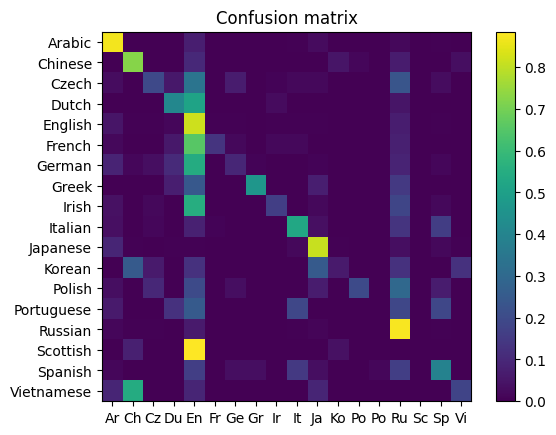

In [142]:
# Confusion matrix
confusion = torch.zeros(N_COUNTRIES, N_COUNTRIES)
accuracy = 0
for name, country, name_tensor, country_tensor in test_loader:
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        hidden, output = rnn(name_tensor[0][i], hidden)
    guess, guess_i = output.topk(1)
    confusion[country_tensor.item(), guess_i.item()] += 1
    if country_tensor.item() == guess_i.item():
        accuracy += 1

# Normalize by dividing every row by its sum
for i in range(N_COUNTRIES):
    confusion[i] = confusion[i] / confusion[i].sum()

# Accuracy
print(f'\nAccuracy: {100*accuracy/len(test_dataset):.2f}%')

# Plot confusion matrix
plt.imshow(confusion.numpy())
plt.colorbar()
plt.title('Confusion matrix')
ax = plt.gca()
positions = list(range(N_COUNTRIES))
labels = train_dataset.dataset.idx_to_country
small_labels = [label[:2] for label in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(small_labels))
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
plt.show()

The accuracy increased! (~74% vs ~60% last time **and we used an independent test set whereas last time we calculated the accuracy on the training set, so it's even more unexpected**)

Let's try on a couple of examples:

In [143]:
# Test on a couple of examples
print(f'NAME; TRUTH; PREDICTED')
for i in range(10):
    name, country, name_tensor, country_tensor = test_dataset[i]
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        hidden, output = rnn(name_tensor[i], hidden)
    print(f'{name}; {country}; {rnn.outputToCountry(output)}')

NAME; TRUTH; PREDICTED
Rademaker; Dutch; English
Zinoviev; Russian; English
Rush; English; English
Bibitinsky; Russian; English
Zhimerin; Russian; English
Lihobaba; Russian; English
Lippi; Italian; English
Absalyamoff; Russian; English
Bazzi; Arabic; English
Avash; Russian; English


Let's try a couple of examples of our own:

In [144]:
names = ["Dubois", "Lhotte", "Dupont", "Garcia", "Sato", "Duprès", "Suzuki", "Wang", "Santos", "Yamamoto"]
for name in names:
    name_tensor = nameToTensor(name)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        hidden, output = rnn(name_tensor[i], hidden)
    print(f'{name}; {rnn.outputToCountry(output)}')

Dubois; English
Lhotte; English
Dupont; English
Garcia; English
Sato; English
Duprès; English
Suzuki; English
Wang; English
Santos; English
Yamamoto; English


It's almost always English/Russian that is predicted*! Why is that?

\* might differ based on the random initialization of the weights, the network is actually overfitting, cf. below.

This is typical of a class unbalance, let's investigate the size of each class:

In [145]:
# cout each country in the dataset with a defaultdict
from collections import defaultdict

countr_count = defaultdict(int)
total = 0
for country in dataset.countries:
    countr_count[country] += 1
    total += 1
print(f'Country; Count; Percentage')
for country, count in countr_count.items():
    print(f'{country}; {count}; {100*count/total:.2f}%')

Country; Count; Percentage
Arabic; 2000; 9.96%
Chinese; 268; 1.34%
Czech; 519; 2.59%
Dutch; 297; 1.48%
English; 3668; 18.27%
French; 277; 1.38%
German; 724; 3.61%
Greek; 203; 1.01%
Irish; 232; 1.16%
Italian; 709; 3.53%
Japanese; 991; 4.94%
Korean; 94; 0.47%
Polish; 139; 0.69%
Portuguese; 74; 0.37%
Russian; 9408; 46.87%
Scottish; 100; 0.50%
Spanish; 298; 1.48%
Vietnamese; 73; 0.36%


Let's calculate the per-class accuracy because accuracy is not a good metric here:

In [147]:
per_class_accuracy_list: list[float] = []
for i in range(N_COUNTRIES):
    fraction_correct = confusion[i, i].item()
    per_class_accuracy_list.append(100*fraction_correct)
print("\n")
print(f'Average per class accuracy: {sum(per_class_accuracy_list)/len(per_class_accuracy_list):.2f}%')



Average per class accuracy: 38.49%


Our confusion matrix is a lot worse than in TD 6b but this is normal, in TD 6b we 1/ did not use _names\_1000_ and 2/ plotted the confusion matrix on the training set, not on the testing set.

---
---
---

## Fixing the unbalanced learning

As we did not want to bother you with unbalanced datasets yet as it was your first RNN, all 18 nationalities were represented with the same number of names in TD 6b. Now that we used `names.txt` instead of `names_1000.txt`, we have an unbalanced dataset. This is what real life looks like.

We ignored this but because the dataset was smaller from some nationalities, you can see that in the last TD's `Vietnamese.txt`, some names appeared several times, which is almost a way of artificially balancing the dataset; except that it biased our accuracy results. Now, we have a realistic accuracy estimation, even if it's high because of the high numbers of Russian names, it's accurate (is it though? cf. below ...).

### 1st fixing idea: modify the dataset

Instead of loading names one by one, choose a country at random, then choose a name at random from this category.
Do this using an iterable dataset (checkout the doc here: https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset).

In [149]:
import random
from torch.utils.data import IterableDataset

# Create a custom dataset
class NamesIterableDataset(IterableDataset):
    def __init__(self, filenames='names/*.txt'):
        # Read data
        self.names = dict()  # country -> list of names
        self.country_to_idx = {}
        self.idx_to_country = []

        for filename in glob.glob(filenames):
            country = os.path.splitext(os.path.basename(filename))[0]
            self.country_to_idx[country] = len(self.country_to_idx)
            self.idx_to_country.append(country)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            self.names[country] = []
            for line in lines:
                self.names[country].append(unicodeToAscii(line))
        self.n_countries = len(self.country_to_idx)

    def countryID(self, country):
        return torch.tensor(self.country_to_idx[country])
    
    def __iter__(self):
        for _ in range(len(self)):
            yield self.__next__()

    def __next__(self):
        # Choose random country
        random_country = random.choice(self.idx_to_country)
        # Choose random name within that country
        name = random.choice(self.names[random_country])
        # Convert everything to tensors
        name_tensor = nameToTensor(name)
        countryID = self.countryID(random_country)
        return (name, random_country, name_tensor, countryID)  # str, str, tensor, tensor
    
    def __len__(self):
        return 16059  # Arbitrary, size of one epoch
    
    def __getitem__(self, idx):
        """
        idx is ignored (why? because of the way we want it to work!), but required by the implementation of __getitem__
        """
        return self.__next__()

# Create dataset object
dataset = NamesIterableDataset('data/names/*.txt')

# Get a sample
name, country, name_tensor, country_tensor = next(dataset)
name, country, name_tensor.shape, country_tensor

('Lucassen', 'Dutch', torch.Size([8, 1, 56]), tensor(3))

Q: Interpret `name_tensor.shape`?

A: `[n_letters_in_name, 1, n_letters_available]`

In [150]:
# Split data into train and test with random_split
TRAIN_FRACTION = 0.8
TRAIN_SIZE = int(TRAIN_FRACTION*len(dataset))
TESET_SIZE = len(dataset)-int(TRAIN_FRACTION*len(dataset))
train_dataset, test_dataset = random_split(dataset, [TRAIN_SIZE, TESET_SIZE])

# Store number of countries in a variable
N_COUNTRIES = dataset.n_countries

# Create a dataloader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # batch_size 1 as names have different lengths !!!
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)  # shuffle = True is not technically necessary

# Get a sample from the dataloader
name_train, country, name_tensor, country_tensor = next(iter(train_loader))
print(name_train, country, name_tensor.shape, country_tensor)
name_test, country, name_tensor, country_tensor = next(iter(test_loader))
print(name_test, country, name_tensor.shape, country_tensor)

('Niall',) ('Irish',) torch.Size([1, 5, 1, 56]) tensor([8])
('Marshall',) ('Scottish',) torch.Size([1, 8, 1, 56]) tensor([15])


In [151]:
for _ in range(100_000):
    name_train, country, name_tensor, country_tensor = next(iter(train_loader))
    name_test, country, name_tensor, country_tensor = next(iter(test_loader))
    assert name_train != name_test

AssertionError: 

Q: It doesn't work ... what happened?
A: getitem doesn't use idx anymore, so when splitting the dataset into train/test, we don't actually separate it ... 

In [153]:
# Create a custom dataset
class NamesIterableDataset(IterableDataset):
    def __init__(self, filenames='names/*.txt', train: bool = True, train_fraction: float = 0.8):
        # Read data
        self.names = dict()  # country -> list of names
        self.country_to_idx = {}
        self.idx_to_country = []

        for filename in glob.glob(filenames):
            country = os.path.splitext(os.path.basename(filename))[0]
            self.country_to_idx[country] = len(self.country_to_idx)
            self.idx_to_country.append(country)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            self.names[country] = []
            for line in lines:
                self.names[country].append(unicodeToAscii(line))
        
        # Split the data into train and test datasets
        if train:
            for country in self.names.keys():
                self.names[country] = self.names[country][:int(train_fraction*len(self.names[country]))]
        else:
            for country in self.names.keys():
                self.names[country] = self.names[country][int(train_fraction*len(self.names[country])):]
        
        self.n_countries = len(self.country_to_idx)


    def countryID(self, country):
        return torch.tensor(self.country_to_idx[country])
    
    def __iter__(self):
        for _ in range(len(self)):
            yield self.__next__()

    def __next__(self):
        # Choose random country
        country = random.choice(self.idx_to_country)
        # Choose random name from this country
        name = random.choice(self.names[country])
        # Convert to tensors
        name_tensor = nameToTensor(name)
        countryID = self.countryID(country)
        return (name, country, name_tensor, countryID)
    
    def __len__(self):
        return 16059  # Arbitrary, size of one epoch
    
    def __getitem__(self, idx):
        """
        idx is ignored (why? because of the way we want it to work!), but required by the implementation of __getitem__
        """
        return self.__next__()

# Create dataset object
train_dataset = NamesIterableDataset('data/names/*.txt', train=True, train_fraction=0.8)
test_dataset = NamesIterableDataset('data/names/*.txt', train=False, train_fraction=0.8)

# Get a sample
name, country, name_tensor, country_tensor = next(train_dataset)
name, country, name_tensor.shape, country_tensor

('Krupala', 'Czech', torch.Size([7, 1, 56]), tensor(2))

In [154]:
# Store number of countries in a variable
N_COUNTRIES = dataset.n_countries

# Create a dataloader
train_loader = DataLoader(train_dataset, batch_size=1)  # shuffle is not a thing
test_loader = DataLoader(test_dataset, batch_size=1)  # shuffle is not a thing

# Get a sample from the dataloader
name_train, country, name_tensor, country_tensor = next(iter(train_loader))
print(name_train, country, name_tensor.shape, country_tensor)
name_test, country, name_tensor, country_tensor = next(iter(test_loader))
print(name_test, country, name_tensor.shape, country_tensor)

('Lathey',) ('English',) torch.Size([1, 6, 1, 56]) tensor([4])
('Zambrano',) ('Spanish',) torch.Size([1, 8, 1, 56]) tensor([16])


In [155]:
for _ in range(100_000):
    name_train, country, name_tensor, country_tensor = next(iter(train_loader))
    name_test, country, name_tensor, country_tensor = next(iter(test_loader))
    assert name_train != name_test

AssertionError: 

Whaaaat? It still doesn't work. Hint: Fakhoury.

By the way, we see that when we said above we were unbiased and corrected what was done last time, we were not completely honest (and therefore the accuracies were not representative of what would happen on an independent dataset). Never believe everything you read!!! ... Although for this particular task, overfitting a bit is not that big of a deal as there is a finite set of names ...

When using my_list = list(set(my_list)), we are not guaranteed to keep the order of the elements (cf. classes on data structures from first year).

In [161]:
L = [10, 1, 2, 3, 5, 4]
print(list(set(L)))

[1, 2, 3, 4, 5, 10]
1
2
3
4
5
10


In [162]:
# Create a custom dataset
class NamesIterableDataset(IterableDataset):
    def __init__(self, filenames='names/*.txt', train: bool = True, train_fraction: float = 0.8):
        # Read data
        self.names = dict()  # country -> list of names
        self.country_to_idx = {}
        self.idx_to_country = []

        for filename in glob.glob(filenames):
            country = os.path.splitext(os.path.basename(filename))[0]
            self.country_to_idx[country] = len(self.country_to_idx)
            self.idx_to_country.append(country)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            self.names[country] = []
            for line in lines:
                self.names[country].append(unicodeToAscii(line))
        
        # Split the data into train and test datasets
        for country in self.names.keys():
            self.names[country] = sorted(list(set(self.names[country])))  
            # It actually seems that sorting is not necessary because sorting* is done when converting a list to a set ("set(L)""), but ...
            # *actualy not true, it's just that he hash of small elements are the elements themselves, but if you have big numbers then it's not the case
            # anymore.
            # For those curious, try:
            # L = [10, 1, 42, 123, 2, 3, 5, 4, 123123, 123123123, 123123123123]
            # for k in set(L):
            #     print(k)
            split_idx = int(train_fraction * len(self.names[country]))
            if train:
                self.names[country] = self.names[country][:split_idx]
            else:
                self.names[country] = self.names[country][split_idx:]

        self.n_countries = len(self.country_to_idx)


    def countryID(self, country):
        return torch.tensor(self.country_to_idx[country])
    
    def __iter__(self):
        for _ in range(len(self)):
            yield self.__next__()

    def __next__(self):
        # Choose random country
        country = random.choice(self.idx_to_country)
        # Choose random name from this country
        name = random.choice(self.names[country])
        # Convert to tensors
        name_tensor = nameToTensor(name)
        countryID = self.countryID(country)
        return (name, country, name_tensor, countryID)
    
    def __len__(self):
        return 16059  # Arbitrary, size of one epoch
    
    def __getitem__(self, idx):
        """
        idx is ignored (why? because of the way we want it to work!), but required by the implementation of __getitem__
        """
        return self.__next__()

# Create dataset object
train_dataset = NamesIterableDataset('data/names/*.txt', train=True, train_fraction=0.8)
test_dataset = NamesIterableDataset('data/names/*.txt', train=False, train_fraction=0.8)

# Get a sample
name, country, name_tensor, country_tensor = next(train_dataset)
name, country, name_tensor.shape, country_tensor

('Habich', 'German', torch.Size([6, 1, 56]), tensor(6))

In [163]:
# Store number of countries in a variable
N_COUNTRIES = dataset.n_countries

# Create a dataloader
train_loader = DataLoader(train_dataset, batch_size=1)  # shuffle is not a thing
test_loader = DataLoader(test_dataset, batch_size=1)  # shuffle is not a thing

# Get a sample from the dataloader
name_train, country, name_tensor, country_tensor = next(iter(train_loader))
print(name_train, country, name_tensor.shape, country_tensor)
name_test, country, name_tensor, country_tensor = next(iter(test_loader))
print(name_test, country, name_tensor.shape, country_tensor)

('Malone',) ('Irish',) torch.Size([1, 6, 1, 56]) tensor([8])
('Schoorl',) ('Dutch',) torch.Size([1, 7, 1, 56]) tensor([3])


In [166]:
for _ in range(100_000):
    name_train, country, name_tensor, country_tensor = next(iter(train_loader))
    name_test, country, name_tensor, country_tensor = next(iter(test_loader))
    assert (name_train != name_test)

AssertionError: 

Whaaat? (if you didn't get an error, re-run it) 

Hint: Murphy. It is what it is though, it's not a _us_ problem this time.

In [165]:
for _ in range(10_000):
    name_train, country_train, name_tensor, country_tensor = next(iter(train_loader))
    name_test, country_test, name_tensor, country_tensor = next(iter(test_loader))
    assert ((name_train, country_train) != (name_test, country_test))

At least we're sure we didn't make anything stupid.

Re-define the RNN and re-train it with our new fancy iterable dataset.
Print the final accuracy, and plot the confusion matrix (which should be closer to the identity matrix).

Epoch: 1/10 (10%)	Loss: 2.64e+04
Epoch: 2/10 (20%)	Loss: 1.54e+04
Epoch: 3/10 (30%)	Loss: 1.17e+04
Epoch: 4/10 (40%)	Loss: 1.00e+04
Epoch: 5/10 (50%)	Loss: 9.31e+03
Epoch: 6/10 (60%)	Loss: 8.71e+03
Epoch: 7/10 (70%)	Loss: 8.34e+03
Epoch: 8/10 (80%)	Loss: 8.03e+03
Epoch: 9/10 (90%)	Loss: 7.91e+03
Epoch: 10/10 (100%)	Loss: 7.77e+03

NAME; TRUTH; PREDICTED
Zhui; Chinese; English
Tosto; Italian; English
an; Vietnamese; Spanish
White; Scottish; English
Valencia; Spanish; English
Sparacello; Italian; English
Richelieu; French; English
Yarker; English; English
Waterfield; English; English
Thomson; Scottish; English

Accuracy: 33.74%


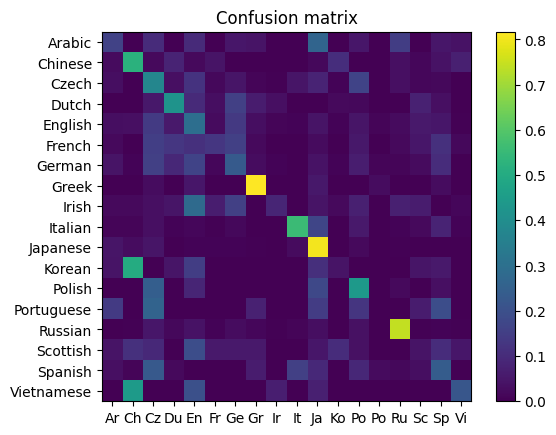

In [168]:
# Create the network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, idx_to_country):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.idx_to_country = idx_to_country
        self.relu = nn.ReLU()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = self.relu(hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def outputToCountry(self, output):
        _, top_i = output.topk(1)
        return self.idx_to_country[top_i[0,0].item()]

    def outputToID(self, output):
        _, top_i = output.topk(1)
        return top_i[0,0].item()

rnn = RNN(N_LETTERS, N_HIDDEN, N_COUNTRIES, dataset.idx_to_country)

# Train the network
lr = 0.001
optimizer = optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.NLLLoss()
n_epochs = 10
for epoch in range(n_epochs):
    loss_sum = 0
    for (name, country, name_tensor, country_tensor) in train_loader:
        hidden = rnn.initHidden()
        rnn.zero_grad()
        for i in range(name_tensor.size()[1]):
            output, hidden = rnn(name_tensor[0][i], hidden)
        loss = criterion(output, country_tensor[0][None])
        loss_sum += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}/{n_epochs} ({100*(epoch+1)/n_epochs:.0f}%)\tLoss: {loss_sum:.2e}')

# Test on a couple of examples
print(f'\nNAME; TRUTH; PREDICTED')
for i in range(10):
    name, country, name_tensor, country_tensor = test_dataset[i]
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[i], hidden)
    print(f'{name}; {country}; {rnn.outputToCountry(output)}')

# Confusion matrix
confusion = torch.zeros(N_COUNTRIES, N_COUNTRIES)
accuracy = 0
for name, country, name_tensor, country_tensor in test_loader:
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[0][i], hidden)
    guess, guess_i = output.topk(1)
    category_i = country_tensor[0][None]
    confusion[category_i, guess_i] += 1
    if category_i == guess_i:
        accuracy += 1
# Normalize by dividing every row by its sum
for i in range(N_COUNTRIES):
    confusion[i] = confusion[i] / confusion[i].sum()
# Accuracy
print(f'\nAccuracy: {100*accuracy/len(test_loader):.2f}%')

# Plot confusion matrix
plt.imshow(confusion.numpy())
plt.colorbar()
plt.title('Confusion matrix')
ax = plt.gca()
positions = list(range(N_COUNTRIES))
labels = train_dataset.idx_to_country
small_labels = [label[:2] for label in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(small_labels))
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
plt.show()

Of course, the accuracy went down again, but at least, our RNN isn't biased (hopefully ... cf. your confusion matrix ...).

In [169]:
names = ["Dubois", "Lhotte", "Dupont", "Garcia", "Sato", "Duprès", "Suzuki", "Wang", "Santos", "Yamamoto"]
for name in names:
    name_tensor = nameToTensor(name)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[i], hidden)
    print(f'{name}; {rnn.outputToCountry(output)}')

Dubois; English
Lhotte; English
Dupont; English
Garcia; English
Sato; English
Duprès; English
Suzuki; English
Wang; English
Santos; English
Yamamoto; English


Let's calculate the per-class accuracy as explained previously:

In [170]:
per_class_accuracy_list: list[float] = []
for i in range(N_COUNTRIES):
    n_correct = confusion[i, i].item()
    n_total = confusion[i].sum().item()
    print(f'{dataset.idx_to_country[i]}: {100*n_correct/n_total:.2f}%')
    per_class_accuracy_list.append(100*n_correct/n_total)
print("\n")
print(f'Average per class accuracy: {sum(per_class_accuracy_list)/len(per_class_accuracy_list):.2f}%')

Arabic: 16.13%
Chinese: 52.11%
Czech: 37.36%
Dutch: 41.96%
English: 29.64%
French: 12.88%
German: 23.01%
Greek: 81.70%
Irish: 8.56%
Italian: 55.56%
Japanese: 80.30%
Korean: 4.33%
Polish: 44.23%
Portuguese: 0.00%
Russian: 74.14%
Scottish: 4.33%
Spanish: 23.64%
Vietnamese: 21.81%


Average per class accuracy: 33.98%


There is still a problem ... Let's find out what it is:

In [171]:
train_dataset.names["French"]

['Abel',
 'Abraham',
 'Adam',
 'Albert',
 'Allard',
 'Archambault',
 'Armistead',
 'Arthur',
 'Augustin',
 'Babineaux',
 'Baudin',
 'Beauchene',
 'Beaulieu',
 'Beaumont',
 'Belanger',
 'Bellamy',
 'Bellerose',
 'Belrose',
 'Berger',
 'Beringer',
 'Bernard',
 'Bertrand',
 'Bisset',
 'Bissette',
 'Blaise',
 'Blanc',
 'Blanchet',
 'Blanchett',
 'Bonfils',
 'Bonheur',
 'Bonhomme',
 'Bonnaire',
 'Bonnay',
 'Bonner',
 'Bonnet',
 'Borde',
 'Bordelon',
 'Bouchard',
 'Boucher',
 'Brisbois',
 'Brodeur',
 'Bureau',
 'Caron',
 'Cavey',
 'Chaput',
 'Charbonneau',
 'Charpentier',
 'Charron',
 'Chastain',
 'Chevalier',
 'Chevrolet',
 'Cloutier',
 'Colbert',
 'Comtois',
 'Cornett',
 'Cote',
 'Coupe',
 'Courtemanche',
 'Cousineau',
 'Couture',
 'Daniau',
 'Daramitz',
 'Daviau',
 'David',
 'De la fontaine',
 'De sauveterre',
 'Deforest',
 'Degarmo',
 'Delacroix',
 'Deniau',
 'Deniaud',
 'Deniel',
 'Denis',
 'Deschamps',
 'Descoteaux',
 'Desjardins',
 'Desrochers',
 'Desrosiers',
 'Dubois',
 'Duchamps',


In [172]:
test_dataset.names["French"]

['Richard',
 'Richelieu',
 'Robert',
 'Roche',
 'Rome',
 'Romilly',
 'Rose',
 'Rousseau',
 'Roux',
 'Roy',
 'Royer',
 'Salomon',
 'Salvage',
 'Samson',
 'Samuel',
 'Sargent',
 'Sarkozi',
 'Sarkozy',
 'Sartre',
 'Sault',
 'Sauvage',
 'Sauvageau',
 'Sauvageon',
 'Sauvageot',
 'Sauveterre',
 'Savatier',
 'Segal',
 'Sergeant',
 'Severin',
 'Simon',
 'Solomon',
 'Soucy',
 'St martin',
 'St pierre',
 'Tailler',
 'Tasse',
 'Thayer',
 'Thibault',
 'Thomas',
 'Tobias',
 'Tolbert',
 'Traver',
 'Travere',
 'Travers',
 'Traverse',
 'Travert',
 'Tremblay',
 'Tremble',
 'Victor',
 'Victors',
 'Villeneuve',
 'Vincent',
 'Vipond',
 'Voclain',
 'Yount']

In [173]:
# Create a custom dataset
class NamesIterableDataset(IterableDataset):
    def __init__(self, filenames='names/*.txt', train: bool = True, train_fraction: float = 0.8):
        # Read data
        self.names = dict()  # country -> list of names
        self.country_to_idx = {}
        self.idx_to_country = []

        for filename in glob.glob(filenames):
            country = os.path.splitext(os.path.basename(filename))[0]
            self.country_to_idx[country] = len(self.country_to_idx)
            self.idx_to_country.append(country)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            self.names[country] = []
            for line in lines:
                self.names[country].append(unicodeToAscii(line))
        
        # Split the data into train and test datasets
        for country in self.names.keys():
            random.seed(1234)
            random.shuffle(list(set(self.names[country])))
            split_idx = int(train_fraction * len(self.names[country]))
            if train:
                self.names[country] = self.names[country][:split_idx]
            else:
                self.names[country] = self.names[country][split_idx:]

        self.n_countries = len(self.country_to_idx)


    def countryID(self, country):
        return torch.tensor(self.country_to_idx[country])
    
    def __iter__(self):
        for _ in range(len(self)):
            yield self.__next__()

    def __next__(self):
        # Choose random country
        country = random.choice(self.idx_to_country)
        # Choose random name from this country
        name = random.choice(self.names[country])
        # Convert to tensors
        name_tensor = nameToTensor(name)
        countryID = self.countryID(country)
        return (name, country, name_tensor, countryID)
    
    def __len__(self):
        return 16059  # Arbitrary, size of one epoch
    
    def __getitem__(self, idx):
        """
        idx is ignored (why? because of the way we want it to work!), but required by the implementation of __getitem__
        """
        return self.__next__()

# Create dataset object
train_dataset = NamesIterableDataset('data/names/*.txt', train=True, train_fraction=0.8)
test_dataset = NamesIterableDataset('data/names/*.txt', train=False, train_fraction=0.8)

# Get a sample
name, country, name_tensor, country_tensor = next(train_dataset)
name, country, name_tensor.shape, country_tensor

('Meeuwes', 'Dutch', torch.Size([7, 1, 56]), tensor(3))

In [174]:
for _ in range(200):
    name, country, name_tensor, country_tensor = next(train_dataset)
    if country == "French":
        print(name, country, name_tensor.shape, country_tensor)

Garcon French torch.Size([6, 1, 56]) tensor(5)
Foss French torch.Size([4, 1, 56]) tensor(5)
Lebeau French torch.Size([6, 1, 56]) tensor(5)
Bouchard French torch.Size([8, 1, 56]) tensor(5)
Favre French torch.Size([5, 1, 56]) tensor(5)
Jordan French torch.Size([6, 1, 56]) tensor(5)
Duguay French torch.Size([6, 1, 56]) tensor(5)
Giles French torch.Size([5, 1, 56]) tensor(5)
Abel French torch.Size([4, 1, 56]) tensor(5)


In [175]:
for _ in range(200):
    name, country, name_tensor, country_tensor = next(test_dataset)
    if country == "French":
        print(name, country, name_tensor.shape, country_tensor)

Thibault French torch.Size([8, 1, 56]) tensor(5)
Sauvageot French torch.Size([9, 1, 56]) tensor(5)
Roy French torch.Size([3, 1, 56]) tensor(5)
Roux French torch.Size([4, 1, 56]) tensor(5)
Thomas French torch.Size([6, 1, 56]) tensor(5)
Segal French torch.Size([5, 1, 56]) tensor(5)
Richelieu French torch.Size([9, 1, 56]) tensor(5)
Tobias French torch.Size([6, 1, 56]) tensor(5)


In [176]:
for _ in range(100_000):
    name_train, country_train, name_tensor, country_tensor = next(iter(train_loader))
    name_test, country_test, name_tensor, country_tensor = next(iter(test_loader))
    assert ((name_train, country_train) != (name_test, country_test))

Epoch: 1/10 (10%)	Loss: 2.65e+04
Epoch: 2/10 (20%)	Loss: 1.52e+04
Epoch: 3/10 (30%)	Loss: 1.18e+04
Epoch: 4/10 (40%)	Loss: 1.01e+04
Epoch: 5/10 (50%)	Loss: 9.42e+03
Epoch: 6/10 (60%)	Loss: 8.73e+03
Epoch: 7/10 (70%)	Loss: 8.40e+03
Epoch: 8/10 (80%)	Loss: 7.81e+03
Epoch: 9/10 (90%)	Loss: 7.99e+03
Epoch: 10/10 (100%)	Loss: 7.75e+03

NAME; TRUTH; PREDICTED
Stamatelos; Greek; English
Zielinski; Polish; English
Simon; Dutch; English
Trieu; Vietnamese; English
Tsai ; Korean; English
Tsogas; Greek; English
Rahal; Arabic; English
Toloni; Italian; English
Stawski; Polish; English
Wyrzyk; Polish; English

Accuracy: 34.50%


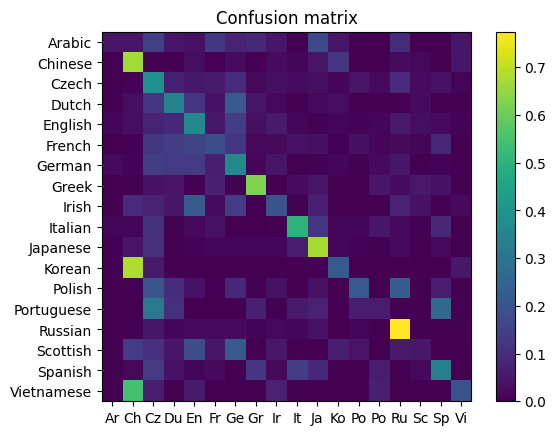

In [177]:
# Create the network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, idx_to_country):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.idx_to_country = idx_to_country
        self.relu = nn.ReLU()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = self.relu(hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def outputToCountry(self, output):
        _, top_i = output.topk(1)
        return self.idx_to_country[top_i[0,0].item()]

    def outputToID(self, output):
        _, top_i = output.topk(1)
        return top_i[0,0].item()

rnn = RNN(N_LETTERS, N_HIDDEN, N_COUNTRIES, dataset.idx_to_country)

# Train the network
lr = 0.001
optimizer = optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.NLLLoss()
n_epochs = 10
for epoch in range(n_epochs):
    loss_sum = 0
    for (name, country, name_tensor, country_tensor) in train_loader:
        hidden = rnn.initHidden()
        rnn.zero_grad()
        for i in range(name_tensor.size()[1]):
            output, hidden = rnn(name_tensor[0][i], hidden)
        loss = criterion(output, country_tensor[0][None])
        loss_sum += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}/{n_epochs} ({100*(epoch+1)/n_epochs:.0f}%)\tLoss: {loss_sum:.2e}')

# Test on a couple of examples
print(f'\nNAME; TRUTH; PREDICTED')
for i in range(10):
    name, country, name_tensor, country_tensor = test_dataset[i]
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[i], hidden)
    print(f'{name}; {country}; {rnn.outputToCountry(output)}')

# Confusion matrix
confusion = torch.zeros(N_COUNTRIES, N_COUNTRIES)
accuracy = 0
for name, country, name_tensor, country_tensor in test_loader:
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[0][i], hidden)
    guess, guess_i = output.topk(1)
    category_i = country_tensor[0][None]
    confusion[category_i, guess_i] += 1
    if category_i == guess_i:
        accuracy += 1
# Normalize by dividing every row by its sum
for i in range(N_COUNTRIES):
    confusion[i] = confusion[i] / confusion[i].sum()
# Accuracy
print(f'\nAccuracy: {100*accuracy/len(test_loader):.2f}%')

# Plot confusion matrix
plt.imshow(confusion.numpy())
plt.colorbar()
plt.title('Confusion matrix')
ax = plt.gca()
positions = list(range(N_COUNTRIES))
labels = train_dataset.idx_to_country
small_labels = [label[:2] for label in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(small_labels))
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
plt.show()

In [178]:
names = ["Dubois", "Lhotte", "Dupont", "Garcia", "Sato", "Duprès", "Suzuki", "Wang", "Santos", "Yamamoto"]
for name in names:
    name_tensor = nameToTensor(name)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[i], hidden)
    print(f'{name}; {rnn.outputToCountry(output)}')

Dubois; English
Lhotte; English
Dupont; English
Garcia; English
Sato; English
Duprès; English
Suzuki; English
Wang; English
Santos; English
Yamamoto; English


In [179]:
per_class_accuracy_list: list[float] = []
for i in range(N_COUNTRIES):
    n_correct = confusion[i, i].item()
    n_total = confusion[i].sum().item()
    print(f'{dataset.idx_to_country[i]}: {100*n_correct/n_total:.2f}%')
    per_class_accuracy_list.append(100*n_correct/n_total)
print("\n")
print(f'Average per class accuracy: {sum(per_class_accuracy_list)/len(per_class_accuracy_list):.2f}%')

Arabic: 4.18%
Chinese: 66.79%
Czech: 39.00%
Dutch: 34.45%
English: 36.68%
French: 18.67%
German: 36.41%
Greek: 62.42%
Irish: 19.75%
Italian: 50.29%
Japanese: 67.14%
Korean: 21.49%
Polish: 21.35%
Portuguese: 6.12%
Russian: 77.46%
Scottish: 4.91%
Spanish: 33.57%
Vietnamese: 19.50%


Average per class accuracy: 34.45%


There is still a bit (a lot) of overfitting though, but that's just hyperparameter optimisation, we won't do it, you lot know how to do it now!

---

### A second (more or less equivalent) "fix": add a sampler to the dataloader

---

### A third (more or less equivalent) "fix": weight the loss function